In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.7.0


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...


C:\Users\guusb\AppData\Local\Temp\ipykernel_3376\4062928930.py:41: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfile.extractall(path=path)


Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


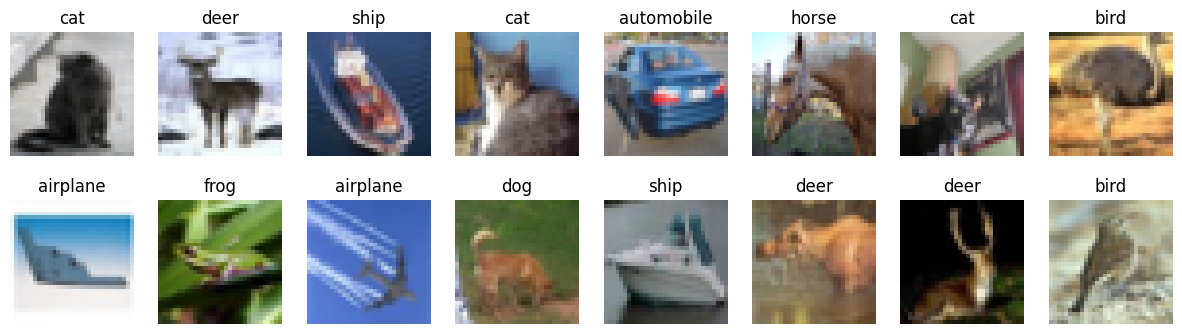

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [44]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers import LeakyReLU

In [ ]:
from tensorflow.keras.optimizers import Adam


# State the inputshape for the model to use
input_shape=(32, 32, 3)

# State a kernel size (3x3) for a (32x32) image is okay
kernel_size = (3,3)

# Function for the neural network
def make_model(input_shape, kernel_size, NUM_CLASSES):
   
    model = Sequential()

    # 2 convolutional layers with 32 neurons each and a 3x3 kernel, for the pooling layer there is a 2x2 kernel
    model.add(Conv2D(32, (kernel_size[0], kernel_size[1]), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (kernel_size[0], kernel_size[1]), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((kernel_size[0]-1, kernel_size[1]-1)))

    # 2 convolutional layers with 64 neurons each and a 3x3 kernel, for the pooling layer there is a 2x2 kernel
    model.add(Conv2D(64, (kernel_size[0], kernel_size[1]), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (kernel_size[0], kernel_size[1]), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((kernel_size[0]-1, kernel_size[1]-1)))
    model.add(Dropout(0.3))

    # 2 convolutional layers with 128 neurons each and a 3x3 kernel, for the pooling layer there is a 2x2 kernel
    model.add(Conv2D(128, (kernel_size[0], kernel_size[1]), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (kernel_size[0], kernel_size[1]), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((kernel_size[0]-1, kernel_size[1]-1)))
    model.add(Dropout(0.4))

    # Flatten the data so the output is a layer with only numbers
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu')) # Bottleneck layer
    model.add(Dense(64, activation='relu'))

    # Output layer with 10 neurons, one for each of the classes
    model.add(Dense(NUM_CLASSES, activation='softmax'))

    return model


The neural network works by taking in the image with the RGB colours. We then use convolutional layers which contian kernels. Kernels are small matrices that take every possible position over the input grid and calculates how likely it is that the patterns that is in the kernel is at that location of the input grid. It calculates the probability for each position and uses that to find patterns in the data. After the first convolutional layer, we normalise the data for better processing of the data. After the convolutional layers we use a pooling layer, which downsamples the conolutiona layers to get better spatial relationships. The pooling layer will look at the outputs of the convolutional layers (so the kernels) and look for the most prominent features in the previous layer, therefore, the main patterns are being found.

Next up we add another two convolutional layers, but with more neurons. Increasing the neurons means the model can find more specific feautres. Again we add a pooling layer and batch normalisation for the same reasons. This time, since we have more neurons, we add a dropout. A dropout randomly makes some of the activated neurons not activate. This results in the model needing to find more general features of the data, ensuring the model is not overtraining and overfitting on the training data, but generalises well on unseen data as well. Dropouts work better on layers with more neurons, if you have a layer with only a few neurons and half of those do not activate, the model struggles to find any patterns in the data. 

Next up we add yet another 2 convolutional layers, containing 128 neurons, Agains the pooling layer and batch normalisation are added. Because we have even more neurons now, we can add a higher dropout.

Now we flatten the data, instead of using kernels, we can now just use neurons that indicate specific numbers. Now each neurons has a specific value indicating which features are present. Now we add a few dense layers to find relationships between the features so we can make even better predictions. We use a bottleneck layer to get better precision. A bottleneck layer is a layer that contains less neurons than the layer before and after it, in this case we go from 32 -> 16 -> 64. This means that the network is able to decrease the complicated input data in just a few parameters. This can be crucial as this teaches the model that certain features can be summarised in just a few parameters, these parameters will not make any sense to humans, yet it is possible to capture a lot of information in these parameters and the model is able to know what these parameters belong to.

For every convolutional and dense layer, there is a relu activation. This function just adds non-linearity to the links between the neurons. This means that the network can find more complex relationships between neurons, thus further improving finding patterns in the data.

After this we can finally have the output layer, where each neuron corresponds to a number for each of the classes, so 10 in our case. Each of these neurons has a value indicating how likely it is that the input data corresponds to that label, the output layer has a softmax activation, which is an activition that gives the sum of the entire output layer to 1. So each neuron in the output layer has a value between 0 and 1 and all those summed up equals one. The network than looks at which neurons has the highest value and predicts that label. 

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# State the learning rate, batch_size and epochs
INIT_LR = 1e-3  # initial learning rate
BATCH_SIZE = 32 # Batch size set to 32 for balance between accuracy and efficiency
EPOCHS = 15 # 15 epochs for balance between accuracy and efficiency


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model(input_shape, kernel_size, NUM_CLASSES)  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=Adam(), # Use the adam optimiser for best optimizing
    metrics=['accuracy']  # report accuracy during training
)

# Inspired by ChatGPT
# This function stops the model from fitting bad parameters
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# fit model
history = model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=[early_stopping, reduce_lr] # Use the functions for better learning process
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")

# Print the usmmary of the model
model.summary()

c:\Users\guusb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 48ms/step - accuracy: 0.3577 - loss: 1.7255 - val_accuracy: 0.3911 - val_loss: 2.0368 - learning_rate: 0.0010
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 50ms/step - accuracy: 0.6251 - loss: 1.0386 - val_accuracy: 0.6809 - val_loss: 0.9207 - learning_rate: 0.0010
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 65s 52ms/step - accuracy: 0.7128 - loss: 0.8194 - val_accuracy: 0.7372 - val_loss: 0.7625 - learning_rate: 0.0010
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.7521 - loss: 0.7120 - val_accuracy: 0.7237 - val_loss: 0.7959 - learning_rate: 0.0010
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 64s 51ms/step - accuracy: 0.7789 - loss: 0.6435 - val_accuracy: 0.6987 - val_loss: 0.9006 - learning_rate: 0.0010
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.7981 - loss: 0.5849 - val_accuracy: 0.7933 - val_loss: 0.6051 - learning_rate: 0.0010
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accura

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           65

 Total params: 1,068,112 (4.07 MB)

 Trainable params: 355,738 (1.36 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 711,478 (2.71 MB)

As we can see from the feedback of the model, there are more than a million total parameter, which might be a bit much, which can lead to overfitting. From the training process from the network we can also see that the accuracy on the training data is a bit higher than the accuracy on the test data, this also indicates that the model is ovefitting. Since the model has higher accuracy on the training data, this indicates that the model is learning the trainigng data and nor generlaising as efficient as it can. Therefore, we can decrease the complexity and increase the dropout for better performance. 

The early stopping function is a function that stops the model from spiraling into bad prameters. If the model uses bad parameters, this function retur back to the previous best parameters.

The reduce LR on Plateau is a functiont that changes the learning rate based on the performance of the model of the validation set, this is useful as if the model is overfitting, this function will tell the model it is overfitting as the validation data will show less accuracy. 

As the optimizer I used the adam optimizer, it is a predefined optimizer from Keras that cleverly teaches the model to adjust its learning rate. The adam optimizer tells the model to change the learning rate based on its performance. 

I used 15 epochs as it a great balance between performance and efficiency. The 15 epochs gives the model enough time to learn meaningful patterns. 

In [123]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

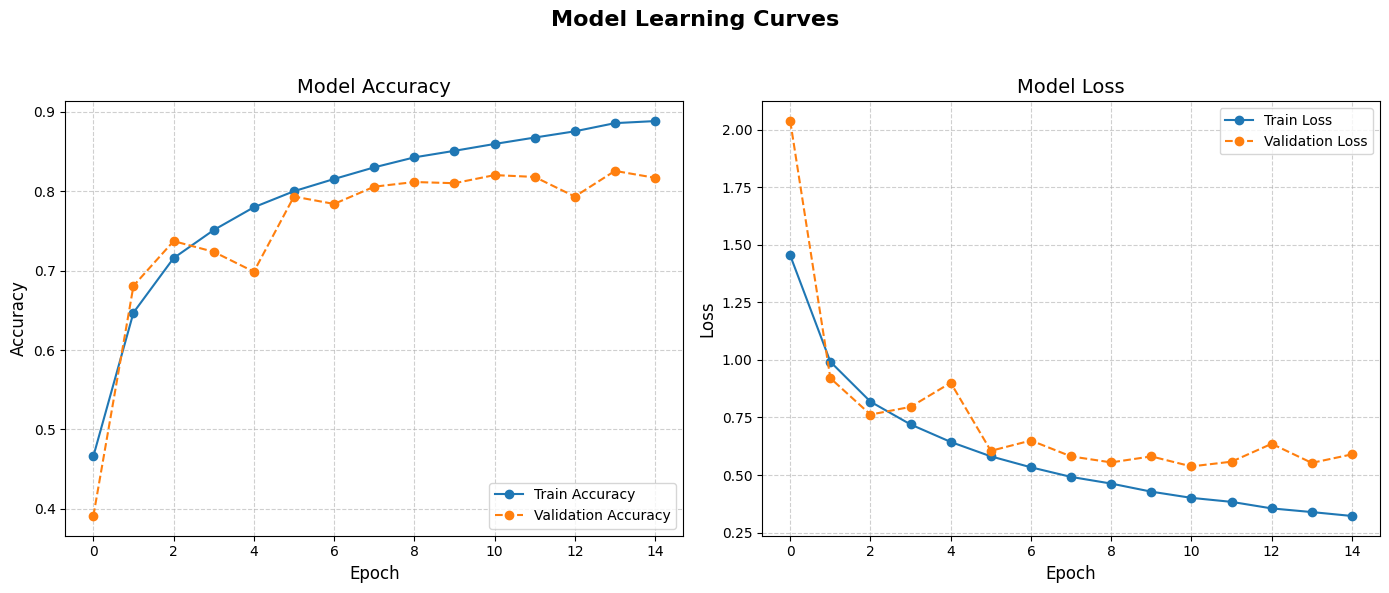

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
              precision    recall  f1-score   support

    airplane       0.80      0.89      0.84      1000
  automobile       0.94      0.89      0.91      1000
        bird       0.78      0.73      0.75      1000
         cat       0.73      0.57      0.64      1000
        deer       0.84      0.78      0.81      1000
         dog       0.64      0.85      0.73      1000
        frog       0.86      0.87      0.87      1000
       horse       0.87      0.85      0.86      1000
        ship       0.92      0.86      0.89      1000
       truck       0.88      0.92      0.90      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



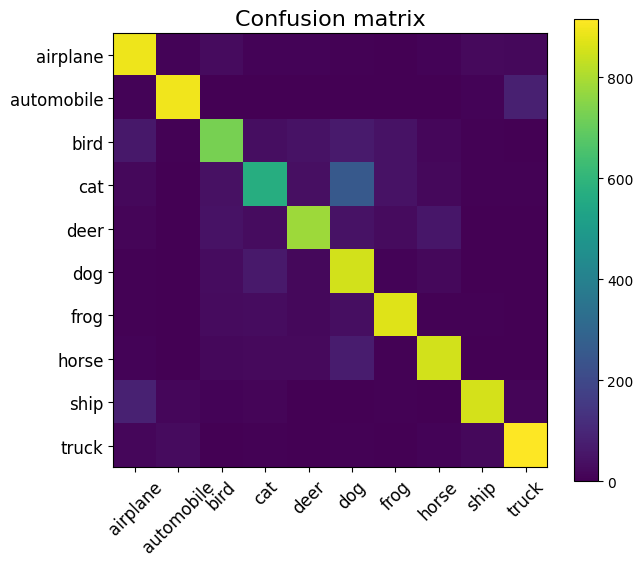

Test accuracy: 0.8206


In [ ]:
# Function for plotting the learning curves and loss functions of the training data and the validation data
def PlotAccuracyAndLoss(history):
    plt.figure(figsize=(14, 6))
    plt.suptitle("Model Learning Curves", fontsize=16, fontweight='bold')

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o', linestyle='-')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='--')
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o', linestyle='-')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', linestyle='--')
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

PlotAccuracyAndLoss(history)

# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]


# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Print the classification report for further analysis of the performance
print(classification_report(y_test_index, y_pred_test_classes, target_names=cifar10_classes))

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()

# Print the accuracy for the model of totally unseen test data, which gives the best insight into the performance
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

As we can see from the data,  the model is relatively good at prediction what the image is of. The accuracy on the totally unseen test data is around 82 percent. This is lower than the accuracy of the training data, which indicates overfitting. 

From the confusion matrix we can see a clear diagnol line, which indicates the model is relatively good at predicting. From the confusion matrix and classification report combined we can see that the model has difficulties with dogs and cats, probably because they have features that are not easy to distinguish, compared to a frog or an airplane. 

From the accuracy and loss function plots, we can see that the training data is pretty smooth, however, the validation data is more fluctuating. This is also an indication of overfitting and therefore, combined with the previous arguments, this model is probably overfitting and will generalise better and probably improve with decreasing the complexity of the model. 

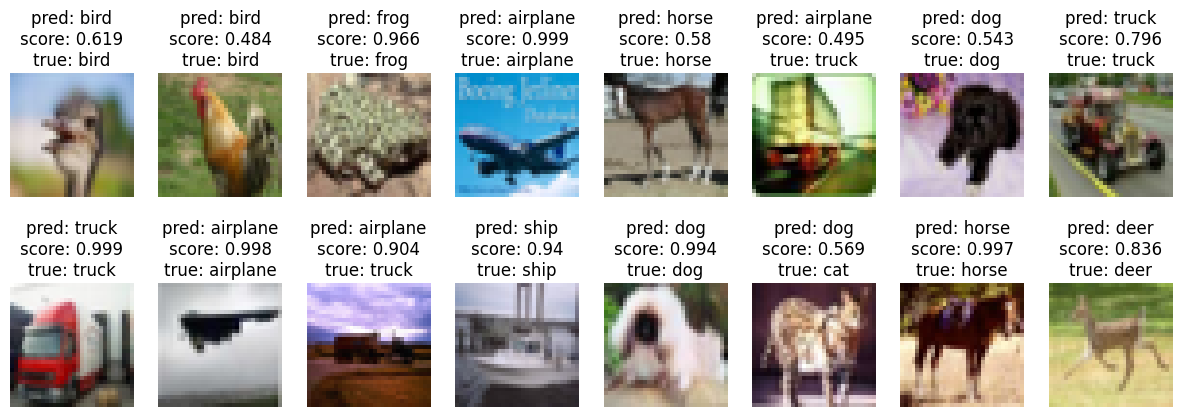

In [ ]:
# Plot 10 samples with the predictions and the true label
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

As we can see from these samples, we can see that the model is predicting relatively well, but there are also many inaccurate predictions. From a limited observation, I think that the model is heavily focussing on the surroudnings of the picture instead of the object or animal itself. For example in the bottem row and the third image on the left, we can see that the model predicts an airplane instead if a truck. This could be due to the picture containing a lot of the blue sky and the model has probably learned to associate blue sky with airplanes.

Ti further improve the model, we should probably address the overfitting and maybe decrease the weights the model gives to colour, so that it focusses mroe on the shape of the image and less on the surroundings. 

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


